In [1]:
import random
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

ModuleNotFoundError: No module named 'plotly'

In [ ]:
# Time series function
def generate_time_series(start_date, end_date, num_products):
    date_range = pd.date_range(start=start_date, end=end_date, freq="D")
    data = {"date": date_range}

    for i in range(1, num_products + 1):
        product_demand = [random.randint(0, 100) for _ in range(len(date_range))]
        data[f'product_{i}_demand'] = product_demand

    df = pd.DataFrame(data=data)
    
    return df

In [ ]:
# Create product demand data
start_date = '2023-01-01'
end_date = '2023-12-31'
num_products = 3

product_demand_data = generate_time_series(start_date, end_date, num_products)
print(product_demand_data)

          date  product_1_demand  product_2_demand  product_3_demand
0   2023-01-01                31                51                81
1   2023-01-02                15                53                44
2   2023-01-03                79                69                81
3   2023-01-04                78                42                58
4   2023-01-05                42               100                90
..         ...               ...               ...               ...
360 2023-12-27                99                79                43
361 2023-12-28                70                91                77
362 2023-12-29                 5                16                69
363 2023-12-30                 3                92                27
364 2023-12-31                26                60                92

[365 rows x 4 columns]


## Time Series Split Cross-Validation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


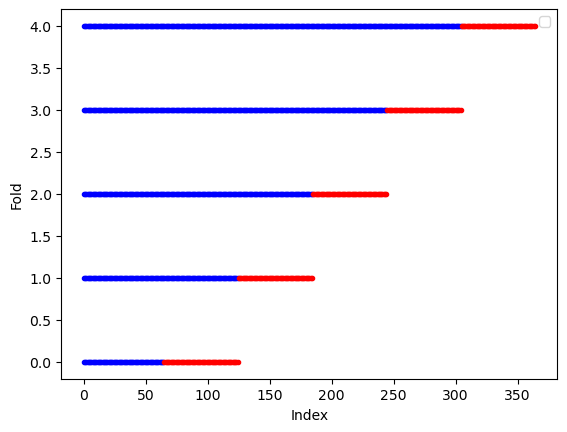

In [ ]:
tscv = TimeSeriesSplit(max_train_size=None, n_splits=5)
folds = []

# Get indices in each fold
for i, (train_index, test_index) in enumerate(tscv.split(product_demand_data["product_1_demand"])):
    folds.append([train_index, test_index])

# Create dfs
folds_df = []
for i in folds:
    df_train = pd.DataFrame(zip(i[0], ['train']*len(i[0])),
                            columns=['index','group'])
    df_test = pd.DataFrame(zip(i[1], ['test']*len(i[1])),
                           columns=['index','group'])
    df = pd.concat([df_train, df_test], axis=0)
    folds_df.append(df)

# Assign the row numbers to each iteration for plotting
list_num = [i[0] for i in list(enumerate(folds))]
list_num.reverse()
list_r = []
for i,j in zip(folds_df, list_num):
    i['k_fold']=[j]*len(i)
    list_r.append(i)
    
df_p = pd.concat(list_r, axis=0)
df_p.head()


In [ ]:
fig = px.bar(df_p, x='index', y='k_fold', color='group',
                 color_discrete_map={'test':'red','train':'blue'})

fig.update_layout(yaxis_showticklabels=False)
fig.show()

In [ ]:
rmse = []

for i, (train_index, test_index) in enumerate(tscv.split(product_demand_data["product_1_demand"])):
    X_train, X_test = product_demand_data["product_1_demand"].iloc[train_index], product_demand_data["product_1_demand"].iloc[test_index]
    print("-------------------------------------")
    print(f"Fold {i + 1}:")
    print("TRAIN indices:", train_index)
    print("TEST indices:", test_index)
    print("")

    # Fit the model on rolling folds
    arima = sm.tsa.ARIMA(X_train, order=(1, 1, 1)).fit()
    predictions = arima.predict(start=X_test.index.values[0], end= X_test.index.values[-1])

    # Calculate RMSE
    true_values = X_test.values
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))
    print("RMSE: {}".format(np.mean(rmse)))


-------------------------------------
Fold 1:
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]
TEST indices: [ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124]

RMSE: 30.72799057416286
-------------------------------------
Fold 2:
TRAIN indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  

### Notes
- Rolling Window
- Leakage (It may introduce leakage from future data to the model. The model will observe future patterns to forecast and try to memorize them.)
- Source: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
- Source: https://towardsdatascience.com/visualizing-sklearn-cross-validation-k-fold-shuffle-split-and-time-series-split-a13221eb5a56

## Blocked Cross-Validation